# Road Network Detection with Deep Learning/Deep Neural Network Approach

Implementasi model deep learning UNet untuk segmentasi jalan raya dari citra satelit.

Sumber (dengan modifikasi): [Github](https://github.com/Anirudh0707/Roads-and-Building-Segmentation)

## Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from tqdm.notebook  import  tqdm
import random

from skimage.util import random_noise

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torchvision.transforms.functional as TF

%matplotlib inline

CUDA = torch.cuda.is_available()
print("CUDA :: ", CUDA)
device = torch.device("cuda" if CUDA else "cpu")

CUDA ::  True


## Dataset

### Download the dataset:

Google Drive digunakan untuk menyimpan checkpoint selama pembuatan model dan model yang digunakan untuk testing. Parameter harap disesuaikan sebelum menjalankan program jika ingin menggunakan Google Drive.

Bagian ini tidak diperlukan jika tidak melakukan training atau model untuk testing dapat di-download/import dari luar.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown 1jKtG9zLamzMYWiyFuZE9D89y4zmgNuL_

Dataset berasal dari [Kaggle](https://www.kaggle.com/datasets/insaff/massachusetts-roads-dataset) yang berisi 13 gambar untuk testing dan 1105 gambar untuk training. Namun, dari 1105 gambar training tersebut, tidak semua gambar memiliki ground truth.

Dataset yang digunakan di bawah ini sudah dihapus gambar yang tidak memiliki ground truth dan sekitar 20% data training dijadikan data validasi.

Struktur dataset dapat dilihat di paling bawah bagian ini.

In [ ]:
!gdown 1pBJeLQ1PqV8ySv5YkjefftzohKO65RKR
!unzip -qq road_segmentation_ideal.zip

Downloading...
From: https://drive.google.com/uc?id=1pBJeLQ1PqV8ySv5YkjefftzohKO65RKR
To: /content/road_segmentation_ideal.zip
100% 4.18G/4.18G [00:53<00:00, 78.5MB/s]


### Dataset structure:

road_segmentation_ideal/
- testing/
  - input/
    - img-1.png
    - ...
  - output/
    - img-1.png
    - ...
- training/
  - input/
    - ...
  - output/
    - ...
- validation/
  - input/
    - ...
  - output/
    - ...

## Modeling

### Set deep learning constant and parameters:

In [ ]:
# UNet Parameter
HIDDEN = 64
KERNEL_SIZE = 3
PADDING = 1
P1 = 0.25
P2 = 0.5

# Dataloader
BATCH = 4

# Paths
image_directory = "/content/road_segmentation_ideal/training/input/"
gt_directory = "/content/road_segmentation_ideal/training/output/"

val_image_directory = "/content/road_segmentation_ideal/validation/input/"
val_gt_directory = "/content/road_segmentation_ideal/validation/output/"

test_image_directory = "/content/road_segmentation_ideal/testing/input/"
test_label_directory = "/content/road_segmentation_ideal/testing/output/"

# Checkpoint Path
PATH = "/content/drive/My Drive/UNet/"
assert os.path.exists(PATH), f"Pastikan folder checkpoint sudah dibuat pada {PATH}"
PATH += "checkpoint_"

# Optimizer
LEARNING_RATE = 0.0001

# Train
RESUME_EPOCH = 130
NUM_EPOCHS = 150
CLASSES_WEIGHTS = [1,7]

# Testing Load Path
# TEST_PATH = "/content/drive/MyDrive/UNet/checkpoint_best.tar"
TEST_PATH = "/content/checkpoint_best.tar"

### Design the neural network architecture (U-Net):

In [ ]:
class UNet(nn.Module):
  def __init__(self, hidden=64, kernel_size=(3,3), padding=(2,2),p1=0.25, p2=0.5):
    super(UNet,self).__init__()
    '''
    Initializes the layers for the neral network model. The UNet arch is used. Number of outputs = 3

    Arguments:
    hidden  --  Number of channels for the first layer. The no of channels for the consequent layers are a multiple of this number
    kernel_size  --  Filter Size for the Conv layers
    padding  --  Padding for the Conv layers. For SAME conv, padding = (kernel_size - 1)/2
    p1 & p2  --  Dropout Layer probabilities

    Return:
    None
    '''
    # 1st Block. Process and Downsample by 2
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden, kernel_size=kernel_size, padding=padding)
    self.conv2 = nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=kernel_size, padding=padding)
    self.max1  = nn.MaxPool2d((2,2), 2)
    self.drop1 = nn.Dropout2d(p=p1)

    # 2nd Block. Process and Downsample by 2
    self.conv3 = nn.Conv2d(in_channels=hidden, out_channels=hidden*2, kernel_size=kernel_size, padding=padding)
    self.conv4 = nn.Conv2d(in_channels=hidden*2, out_channels=hidden*2, kernel_size=kernel_size, padding=padding)
    self.max2  = nn.MaxPool2d((2,2), 2)
    self.drop2 = nn.Dropout2d(p=p2)

    # 3rd Block. Process and Downsample by 2
    self.conv5 = nn.Conv2d(in_channels=hidden*2, out_channels=hidden*4, kernel_size=kernel_size, padding=padding)
    self.conv6 = nn.Conv2d(in_channels=hidden*4, out_channels=hidden*4, kernel_size=kernel_size, padding=padding)
    self.max3  = nn.MaxPool2d((2,2), 2)
    self.drop3 = nn.Dropout2d(p=p2)

    # 4th Block. Process and Downsample by 2
    self.conv7 = nn.Conv2d(in_channels=hidden*4, out_channels=hidden*8, kernel_size=kernel_size, padding=padding)
    self.conv8 = nn.Conv2d(in_channels=hidden*8, out_channels=hidden*8, kernel_size=kernel_size, padding=padding)
    self.max4  = nn.MaxPool2d((2,2), 2)
    self.drop4 = nn.Dropout2d(p=p2)

    # 5th Block. Process and increase channels
    self.conv9  = nn.Conv2d(in_channels=hidden*8, out_channels=hidden*16, kernel_size=kernel_size, padding=padding)
    self.conv10 = nn.Conv2d(in_channels=hidden*16, out_channels=hidden*16 , kernel_size=kernel_size, padding=padding)

    # 6th Block. Upsample by 2
    self.deconv1 = nn.ConvTranspose2d(in_channels=hidden*16, out_channels=hidden*8, kernel_size=kernel_size, padding=padding, stride=2)
    self.drop5 = nn.Dropout2d(p=p2)
    self.conv11 = nn.Conv2d(in_channels=hidden*16, out_channels=hidden*8, kernel_size=kernel_size, padding=padding)
    self.conv12 = nn.Conv2d(in_channels=hidden*8, out_channels=hidden*8 , kernel_size=kernel_size, padding=padding)

    # 7th Block. Upsample by 2
    self.deconv2 = nn.ConvTranspose2d(in_channels=hidden*8, out_channels=hidden*4, kernel_size=kernel_size, padding=padding, stride=2)
    self.drop6 = nn.Dropout2d(p=p2)
    self.conv13 = nn.Conv2d(in_channels=hidden*8, out_channels=hidden*4, kernel_size=kernel_size, padding=padding)
    self.conv14 = nn.Conv2d(in_channels=hidden*4, out_channels=hidden*4 , kernel_size=kernel_size, padding=padding)

    # 8th Block. Upsample by 2
    self.deconv3 = nn.ConvTranspose2d(in_channels=hidden*4, out_channels=hidden*2, kernel_size=kernel_size, padding=padding, stride=2)
    self.drop7 = nn.Dropout2d(p=p2)
    self.conv15 = nn.Conv2d(in_channels=hidden*4, out_channels=hidden*2, kernel_size=kernel_size, padding=padding)
    self.conv16 = nn.Conv2d(in_channels=hidden*2, out_channels=hidden*2 , kernel_size=kernel_size, padding=padding)

    # 9th Block. Upsample by 2
    self.deconv4 = nn.ConvTranspose2d(in_channels=hidden*2, out_channels=hidden, kernel_size=kernel_size, padding=padding, stride=2)
    self.drop8 = nn.Dropout2d(p=p2)
    self.conv17 = nn.Conv2d(in_channels=2*hidden, out_channels=hidden, kernel_size=kernel_size, padding=padding)
    self.conv18 = nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=kernel_size, padding=padding)

    self.output = nn.Conv2d(in_channels=hidden, out_channels=2, kernel_size=kernel_size, padding=padding)

  def forward(self, x):
    '''
    Forward propogation of the model. The image is first downsampled and the upsampled
    Leaky ReLU is used for the Conv Layer activations

    Arguments:
    x  --  Input to the U-Net

    Returns
    y  --  Output of the U-Net. Output is the logits and not the softmax probabilities
    '''
    x = nn.LeakyReLU()(self.conv1(x))
    x = nn.LeakyReLU()(self.conv2(x))
    x_2 = self.max1(x)
    x_2 = self.drop1(x_2)

    x_2 = nn.LeakyReLU()(self.conv3(x_2))
    x_2 = nn.LeakyReLU()(self.conv4(x_2))
    x_4 = self.max2(x_2)
    x_4 = self.drop2(x_4)

    x_4 = nn.LeakyReLU()(self.conv5(x_4))
    x_4 = nn.LeakyReLU()(self.conv6(x_4))
    x_8 = self.max3(x_4)
    x_8 = self.drop3(x_8)

    x_8 = nn.LeakyReLU()(self.conv7(x_8))
    x_8 = nn.LeakyReLU()(self.conv8(x_8))
    x_16 = self.max4(x_8)
    x_16 = self.drop4(x_16)

    x_16 = nn.LeakyReLU()(self.conv9(x_16))
    y_16 = nn.LeakyReLU()(self.conv10(x_16))

    y_8 = self.deconv1(y_16, output_size=x_8.size())
    y_8 = torch.cat((y_8, x_8), axis = 1)
    y_8 = nn.LeakyReLU()(self.conv11(y_8))
    y_8 = nn.LeakyReLU()(self.conv12(y_8))

    y_4 = self.deconv2(y_8, output_size=x_4.size())
    y_4 = torch.cat((y_4, x_4), axis=1)
    y_4 = nn.LeakyReLU()(self.conv13(y_4))
    y_4 = nn.LeakyReLU()(self.conv14(y_4))

    y_2 = self.deconv3(y_4, output_size=x_2.size())
    y_2 = torch.cat((y_2, x_2), axis=1)
    y_2 = nn.LeakyReLU()(self.conv15(y_2))
    y_2 = nn.LeakyReLU()(self.conv16(y_2))

    y_1 = self.deconv4(y_2, output_size=x.size())
    y_1 = torch.cat((y_1, x), axis=1)
    y_1 = nn.LeakyReLU()(self.conv17(y_1))
    y_1 = nn.LeakyReLU()(self.conv18(y_1))
    y = self.output(y_1)
    return y

### Set data loader:

Berfungsi untuk memuat gambar ke dalam VRAM secara satu per satu untuk mengurangi kebutuhan memory.

In [ ]:
class SegmentationDatasetLoader(object):
  def __init__(self, img_root_dir, gt_root_dir, train = False, add_noise = False):
    '''
    Initialize the Dataloader

    Arguments:
    img_root_dir  --  Directory containing the input image files
    gt_root_dir   --  Directory containing the output label files
    train  --  Variable tto differentiate between traning and test/val for data augmentation and transforms

    Returns:
    None
    '''
    self.img_root_dir = img_root_dir
    self.gt_root_dir = gt_root_dir
    self.img_list = os.listdir(img_root_dir)
    self.gt_list  = os.listdir(gt_root_dir)
    self.img_list.sort()
    self.gt_list.sort()
    self.train = train
    self.add_noise = add_noise

  def __getitem__(self, idx):
    '''
    Based on the input index, reads a filen and the corresponding target and outputs both as processed tensors to the net

    Arguments:
    idx  --  The index of the dataframe row to be loaded

    Returns:
    img  --  The image tensor of dimension [batch,channels,height,width]
    gt   --  The target for the image loaded in a tensor format [batch,1,height,width]
    '''
    dim = 512
    img = Image.open(os.path.join(self.img_root_dir, self.img_list[idx]))
    gt = cv2.imread(os.path.join(self.gt_root_dir, self.gt_list[idx]))

    if self.add_noise:
      img = np.array(img)
      img = random_noise(img, mode='gaussian', var=0.01)
      img = (255 * img).astype(np.uint8)
      img = Image.fromarray(img)

    # Make the white color as green for one hot encoding
    gt = gt[:,:,[2,1,0]]
    gt[:,:,0] = gt[:,:,0] - gt[:,:,1]
    gt[:,:,2] = gt[:,:,2] - gt[:,:,1]
    gt = Image.fromarray(gt, 'RGB')

    # Resize to a power of 2
    img = TF.resize(img, (dim, dim))
    gt = TF.resize(gt, (dim, dim))

    # Transform only for the training phase
    if self.train:
      if random.random() > 0.5:
        img = TF.vflip(img)
        gt  = TF.vflip(gt)
      if random.random() > 0.5:
        img = TF.hflip(img)
        gt  = TF.hflip(gt)
      if random.random() > 0.5:
        angle = random.randint(0, 45)
        img = TF.rotate(img, angle)
        gt  = TF.rotate(gt,  angle)

    # Convert to a tensor from a PIL Image
    img = TF.to_tensor(img)
    gt  = TF.to_tensor(gt)
    gt  = torch.argmax(gt, dim = 0)
    return img.type(torch.float), gt.type(torch.long)

  def __len__(self):
    '''
    Calculate the number of file/data-points in the directory

    Arguments:
    None

    Returns:
    Number of files
    '''
    return len(self.img_list)

### Set metric (IoU) calculator:

Metrik yang digunakan adalah IoU karena kita akan mementingkan prediksi jalanan yang benar sebaik mungkin.

In [ ]:
def IoU(input, target):
  '''
  Calcualtes the IoU Coefficeint for the 2 specified images

  Arguments:
  pred  --  The predicted image by the neural network
  target  --  The ground truth image/segmented image

  Returns
  iou.item()  --  The IoU Co-efficient(float) for the predicted image and the ground-truth image
  '''
  smooth = 1.  # Factor to prevent NaN and maintain smoothness
  pred = nn.Softmax2d()(input)  # Apply Softmax since the network outputs the logits
  target = target.unsqueeze(1)
  target = torch.cat((target==0, target==1), dim=1).type(torch.float)  # Accomodate both channels
  intersection = (pred * target).sum(dim=(1,2,3))
  union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection
  return ((intersection + smooth)/(union + smooth)).mean().item()

## Model Fitting

### Instatiate model:

In [ ]:
segmentation_model = UNet(
  hidden=HIDDEN, kernel_size=KERNEL_SIZE, padding=PADDING, p1=P1, p2=P2
  ).to(device)

### Set optimizer:

In [ ]:
optimizer = torch.optim.Adam(
  segmentation_model.parameters(), lr = LEARNING_RATE)

### Set loss function:

In [ ]:
criterion_cross = nn.CrossEntropyLoss(
  weight = torch.tensor(CLASSES_WEIGHTS, dtype=torch.float).to(device))

## Training

### Setup training images:

In [ ]:
# Instantiate the Training DataLoader and Data Iterator
segmentation_dataset = SegmentationDatasetLoader(
  image_directory, gt_directory, train = True)
segmentation_iter = torch.utils.data.DataLoader(
  segmentation_dataset, batch_size=BATCH, shuffle=True)

# Instantiate the Validation Data Loader and Data Iterator
val_dataset = SegmentationDatasetLoader(
  val_image_directory, val_gt_directory)
val_iter = torch.utils.data.DataLoader(
  val_dataset, batch_size=BATCH, shuffle=False)

### Start the training:

In [ ]:
loss_train = []
best_iou = 0

# Get train and valid iteration size
iterations = len(segmentation_iter)
val_iterations = len(val_iter)

# Resume Check
if RESUME_EPOCH == 0:
  print("Starting Training Loop...")

else:
  with open(PATH + 'best_iou.txt', 'r') as f:
    best_iou = float(f.read())

  checkpoint = torch.load(PATH + str(RESUME_EPOCH) + '.tar', map_location=device)
  segmentation_model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print("Resuming Training Loop...")


# Training Loop
for epoch in range(RESUME_EPOCH, NUM_EPOCHS):
  loss_epoch = 0
  iou = 0
  iou_val = 0
  segmentation_model.train()
  for img, label in tqdm(segmentation_iter):
    img = img.to(device)
    label = label.to(device)
    optimizer.zero_grad()

    output = segmentation_model(img)
    loss = criterion_cross(output, label)
    loss_epoch += loss.item()

    # Metrics for Training
    iou  +=  IoU(output.clone().detach(), label.clone().detach())

    # Backprop
    loss.backward()
    optimizer.step()

  loss_train.append(loss_epoch)
  print(f"Epoch: {epoch+1}  Loss: {loss_epoch}")
  print(f"Training   IoU: {iou/iterations}")
  if (epoch+1) % 10 == 0:
    torch.save({
      'epoch': epoch+1,
      'model_state_dict': segmentation_model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss_epoch}, PATH+str(epoch+1)+'.tar')

  # Validation
  segmentation_model.eval()
  with torch.no_grad():
    for img_val, label_val in val_iter:
      img_val, label_val = img_val.to(device), label_val.to(device)
      output_val = segmentation_model(img_val)
      # Metrics for the Validation
      iou_val  +=  IoU(output_val.clone().detach(), label_val.clone().detach())
  print(f"Validation IoU: {iou_val/val_iterations}")

  if iou_val > best_iou:
    best_iou = iou_val
    torch.save({
      'epoch': epoch+1,
      'model_state_dict': segmentation_model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss_epoch}, PATH+'best.tar')

    with open(PATH + 'best_iou.txt', 'w') as f:
      f.write(str(best_iou))

    print(f"Best model found on epoch {epoch+1}")

  print()

Resuming Training Loop...


  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 131  Loss: 31.820728600025177
Training   IoU: 0.8158449109643697
Validation IoU: 0.8001377642154693



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 132  Loss: 31.768317125737667
Training   IoU: 0.8169749516993761
Validation IoU: 0.7945942476391792



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 133  Loss: 31.50771590322256
Training   IoU: 0.8179007280617953
Validation IoU: 0.8297461211681366



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 134  Loss: 31.614088229835033
Training   IoU: 0.8169402528554202
Validation IoU: 0.8177375614643096



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 135  Loss: 31.57227722555399
Training   IoU: 0.8188509702682495
Validation IoU: 0.8179463103413582



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 136  Loss: 32.73264014720917
Training   IoU: 0.8131890427321196
Validation IoU: 0.8110468491911889



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 137  Loss: 31.627896338701248
Training   IoU: 0.8166311483830213
Validation IoU: 0.7918615192174911



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 138  Loss: 31.665418833494186
Training   IoU: 0.8177858967334032
Validation IoU: 0.806829959154129



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 139  Loss: 31.632303431630135
Training   IoU: 0.8159345559775829
Validation IoU: 0.8310263901948929



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 140  Loss: 31.258767157793045
Training   IoU: 0.8201112225651741
Validation IoU: 0.8074693605303764



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 141  Loss: 32.03097876906395
Training   IoU: 0.814590921625495
Validation IoU: 0.8280279353260994



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 142  Loss: 31.45584548264742
Training   IoU: 0.8184129644185305
Validation IoU: 0.7565861105918884



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 143  Loss: 31.442921794950962
Training   IoU: 0.8178376231342555
Validation IoU: 0.7886671721935272



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 144  Loss: 30.936036325991154
Training   IoU: 0.8204503726214171
Validation IoU: 0.8408882156014442



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 145  Loss: 31.336214818060398
Training   IoU: 0.8190788216888905
Validation IoU: 0.8181221261620522



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 146  Loss: 30.949796803295612
Training   IoU: 0.8204201236367226
Validation IoU: 0.8431203022599221



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 147  Loss: 31.213175520300865
Training   IoU: 0.8193376526236534
Validation IoU: 0.8065193578600883



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 148  Loss: 30.631646037101746
Training   IoU: 0.8228980589658021
Validation IoU: 0.8125574514269829



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 149  Loss: 30.831543639302254
Training   IoU: 0.8208084397017956
Validation IoU: 0.8146135002374649



  0%|          | 0/160 [00:00<?, ?it/s]

Epoch: 150  Loss: 31.027787514030933
Training   IoU: 0.8210052870213985
Validation IoU: 0.822053188085556



## Testing

### Setup testing images:

In [ ]:
test_dataset = SegmentationDatasetLoader(
  test_image_directory, test_label_directory)
test_iter = torch.utils.data.DataLoader(
  test_dataset, batch_size=BATCH)

### Start testing:

In [ ]:
iou_test  = 0
test_iterations = len(test_iter)

# Load model state dictionary
checkpoint = torch.load(TEST_PATH, map_location=device)
segmentation_model.load_state_dict(checkpoint['model_state_dict'])
segmentation_model.eval()

# Test Loop
with torch.no_grad():
  for img_test, label_test in tqdm(test_iter):
    img_test, label_test = img_test.to(device), label_test.to(device)
    output_test = segmentation_model(img_test)

    # Metrics for the Testing
    iou_test  +=  IoU(output_test.clone().detach(), label_test.clone().detach())
print(f"Test IoU: {iou_test/test_iterations}")

  0%|          | 0/4 [00:00<?, ?it/s]

Test IoU: 0.8310990035533905


### Test on one image for an overview:

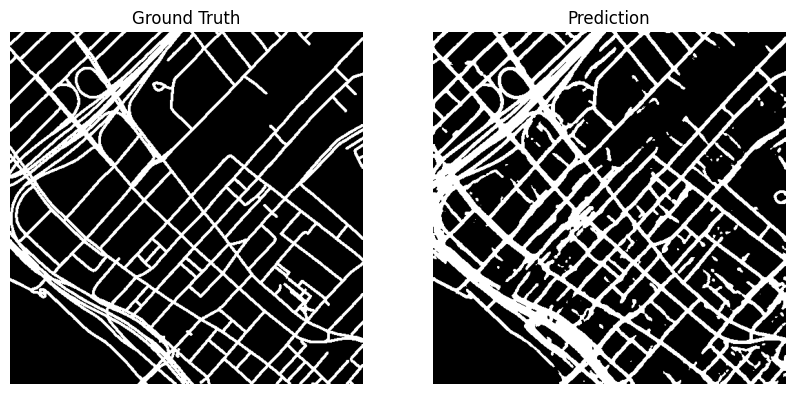

In [ ]:
# Load Model Data
checkpoint = torch.load(TEST_PATH, map_location=device)
segmentation_model.load_state_dict(checkpoint['model_state_dict'])

# Ready for Testing
segmentation_model.eval()
img , gt = test_dataset.__getitem__(0)
img = img.to(device)
gt = gt.squeeze().numpy()

# Get the class indicies
out = nn.Softmax2d()(segmentation_model(img.unsqueeze(0)))
pred = np.argmax(out.squeeze(0).detach().cpu().numpy(), axis = 0)

# Prepare the image representation for prediction and ground truth
pred = pred[np.newaxis,:,:]
pred = np.concatenate((pred==0,pred==1), axis=0)

gt = gt[np.newaxis,:,:]
gt = np.concatenate((gt==0,gt==1), axis=0)

# Push channels to the last dim
gt = np.transpose(gt, (1,2,0)).astype(float)
pred = np.transpose(pred, (1,2,0)).astype(float)

# Convert 2-channel images to grayscale
gt_gray = gt[:,:,1]
pred_gray = pred[:,:,1]


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gt_gray, cmap='gray')
plt.axis('off')
plt.title('Ground Truth')

plt.subplot(1, 2, 2)
plt.imshow(pred_gray, cmap='gray')
plt.axis('off')
plt.title('Prediction')

plt.show()

### Add noise to testing images:

In [ ]:
noisy_test_dataset = SegmentationDatasetLoader(
  test_image_directory, test_label_directory, add_noise=True)
noisy_test_iter = torch.utils.data.DataLoader(
  noisy_test_dataset, batch_size=BATCH)

### Start testing with noise added images:

In [ ]:
iou_test  = 0
test_iterations = len(noisy_test_iter)

# Load model state dictionary
checkpoint = torch.load(TEST_PATH, map_location=device)
segmentation_model.load_state_dict(checkpoint['model_state_dict'])
segmentation_model.eval()

# Test Loop
with torch.no_grad():
  for img_test, label_test in tqdm(noisy_test_iter):
    img_test, label_test = img_test.to(device), label_test.to(device)
    output_test = segmentation_model(img_test)

    # Metrics for the Testing
    iou_test  +=  IoU(output_test.clone().detach(), label_test.clone().detach())
print(f"Test IoU: {iou_test/test_iterations}")

  0%|          | 0/4 [00:00<?, ?it/s]

Test IoU: 0.8041467815637589


### Test on one noise added image for an overview:

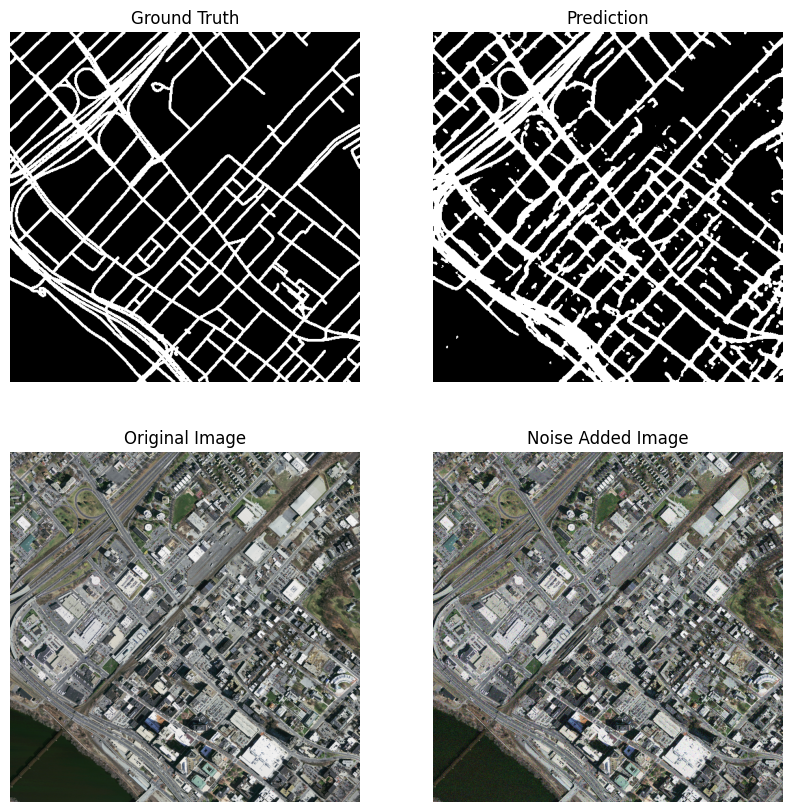

In [ ]:
# Setup a noise added image
real_img = Image.open(os.path.join(test_image_directory, "img-1.png"))
noisy_img = np.array(real_img)
noisy_img = random_noise(noisy_img, mode='gaussian', var=0.01)
noisy_img = (255 * noisy_img).astype(np.uint8)
noisy_img = Image.fromarray(noisy_img)

# Load Model Data
checkpoint = torch.load(TEST_PATH, map_location=device)
segmentation_model.load_state_dict(checkpoint['model_state_dict'])

# Ready for Testing
segmentation_model.eval()
img , gt = noisy_test_dataset.__getitem__(0)
img = img.to(device)
gt = gt.squeeze().numpy()

# Get the class indicies
out = nn.Softmax2d()(segmentation_model(img.unsqueeze(0)))
pred = np.argmax(out.squeeze(0).detach().cpu().numpy(), axis = 0)

# Prepare the image representation for prediction and ground truth
pred = pred[np.newaxis,:,:]
pred = np.concatenate((pred==0,pred==1), axis=0)

gt = gt[np.newaxis,:,:]
gt = np.concatenate((gt==0,gt==1), axis=0)

# Push channels to the last dim
gt = np.transpose(gt, (1,2,0)).astype(float)
pred = np.transpose(pred, (1,2,0)).astype(float)

# Convert 2-channel images to grayscale
gt_gray = gt[:,:,1]
pred_gray = pred[:,:,1]


plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(gt_gray, cmap='gray')
plt.axis('off')
plt.title('Ground Truth')

plt.subplot(2, 2, 2)
plt.imshow(pred_gray, cmap='gray')
plt.axis('off')
plt.title('Prediction')

plt.subplot(2, 2, 3)
plt.imshow(real_img)
plt.axis('off')
plt.title('Original Image')

plt.subplot(2, 2, 4)
plt.imshow(noisy_img)
plt.axis('off')
plt.title('Noise Added Image')

plt.show()